# Часть I: Исследование одной характеристики

**Гипотезы**  
- $H_0$: $\xi\sim N(0,1)$  
- $H_1$: $\xi\sim \mathrm{Laplace}(0,\sqrt{1/2})$  

**Методы**  
1. **KNN-граф** ($k=3$) → $t(G)$ — число треугольников  
2. **DIST-граф** ($d=0.6$) → $\omega(G)$ — кликовое число  
3. **χ²-тест** по 10 равноправным бинам, уровень $\alpha=0.05$  


In [2]:
# 1) Настройка среды и импорты
import sys
sys.path.append('..')  # чтобы Python увидел папку src/

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.stats import norm, laplace, chisquare

from src.generators import sample_h0, sample_h1
from src.graphs import build_knn_graph, build_distance_graph
from src.features import compute_triangles, compute_clique_number_1d

In [3]:
# 2) Параметры эксперимента
n      = 1000    # размер выборки
M      = 1000    # число симуляций
alpha  = 0.05    # уровень значимости
k_knn  = 3       # параметр k
d_dist = 0.6     # радиус d
beta0  = np.sqrt(0.5)  # Laplace scale

In [4]:
# 3) Monte-Carlo: генерируем M выборок для H0 и H1
h0_samples = [sample_h0(n) for _ in tqdm(range(M), desc='Gen H0')]
h1_samples = [sample_h1(n, beta0) for _ in tqdm(range(M), desc='Gen H1')]

Gen H1: 100%|████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5037.88it/s]


In [5]:
# 4a) KNN-граф: t(G) — число треугольников
tri0 = [compute_triangles(build_knn_graph(x, k_knn)) for x in tqdm(h0_samples, desc='KNN H0')]
tri1 = [compute_triangles(build_knn_graph(x, k_knn)) for x in tqdm(h1_samples, desc='KNN H1')]

# 4b) DIST-граф: ω(G) — кликовое число
from src.features import compute_clique_number_1d

clique0 = [
    compute_clique_number_1d(x, d_dist)
    for x in tqdm(h0_samples, desc='CLIQUE H0')
]
clique1 = [
    compute_clique_number_1d(x, d_dist)
    for x in tqdm(h1_samples, desc='CLIQUE H1')
]

CLIQUE H1: 100%|██████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 530.36it/s]


In [6]:
# 5) χ²-тест по 10 equiprobable бинам, рассчитанным от H0
num_bins  = 10
probs     = np.linspace(0, 1, num_bins+1)
bin_edges = norm.ppf(probs, loc=0, scale=1)

def stat_chi2(x):
    obs, _ = np.histogram(x, bins=bin_edges)
    exp    = np.full(num_bins, len(x)/num_bins)
    return chisquare(f_obs=obs, f_exp=exp)

p0 = [stat_chi2(x)[1] for x in tqdm(h0_samples, desc='Chi2 H0')]
p1 = [stat_chi2(x)[1] for x in tqdm(h1_samples, desc='Chi2 H1')]

type1_chi2 = np.mean(np.array(p0) < alpha)
power_chi2 = np.mean(np.array(p1) < alpha)

Chi2 H1: 100%|███████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1836.57it/s]


Sweep KNN (t):


,k,power
0,1,0.000
1,2,0.055
2,3,0.052
3,5,0.069
4,7,0.072
5,10,0.063



Sweep DIST (ω):


,d,power
0,0.2,1.0
1,0.4,1.0
2,0.6,1.0
3,0.8,1.0
4,1.0,1.0


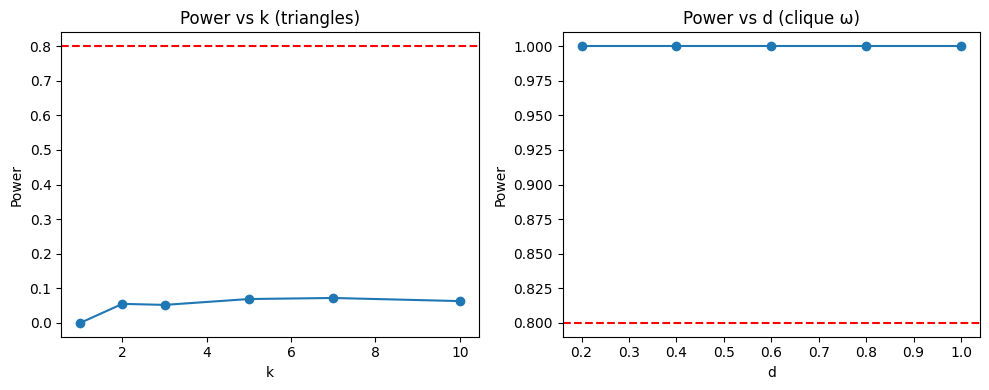

In [7]:
# === 5.5) Sweep-поиск по k и d ===

# диапазоны параметров
ks = [1,2,3,5,7,10]
ds = [0.2,0.4,0.6,0.8,1.0]

# функция, возвращающая мощность одного критерия
def estimate_power(vals0, vals1, alpha=0.05):
    crit = np.percentile(vals0, 100*(1-alpha))
    return np.mean(np.array(vals1) > crit)

# 5.5a) Sweep для KNN-графа (t(G))
results_knn = []
for k in ks:
    t0 = [compute_triangles(build_knn_graph(x, k)) for x in h0_samples]
    t1 = [compute_triangles(build_knn_graph(x, k)) for x in h1_samples]
    beta = estimate_power(t0, t1, alpha)
    results_knn.append({'k': k, 'power': beta})
    
# 5.5b) Sweep для DIST-графа (ω(G))
from src.features import compute_clique_number_1d
results_dist = []
for d in ds:
    c0 = [compute_clique_number_1d(x, d) for x in h0_samples]
    c1 = [compute_clique_number_1d(x, d) for x in h1_samples]
    beta = estimate_power(c0, c1, alpha)
    results_dist.append({'d': d, 'power': beta})

# Оборачиваем в DataFrame и отображаем
df_knn = pd.DataFrame(results_knn)
df_dist = pd.DataFrame(results_dist)

print("Sweep KNN (t):")
display(df_knn)
print("\nSweep DIST (ω):")
display(df_dist)

# И — для наглядности — пара графиков
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(df_knn['k'], df_knn['power'], marker='o')
plt.axhline(0.8, color='r', linestyle='--')
plt.title('Power vs k (triangles)')
plt.xlabel('k'); plt.ylabel('Power')

plt.subplot(1,2,2)
plt.plot(df_dist['d'], df_dist['power'], marker='o')
plt.axhline(0.8, color='r', linestyle='--')
plt.title('Power vs d (clique ω)')
plt.xlabel('d'); plt.ylabel('Power')

plt.tight_layout()
plt.show()


In [8]:
# 6) Оценка критических порогов и мощностей

crit_tri  = np.percentile(tri0, 100*(1-alpha))
power_tri = np.mean(np.array(tri1) > crit_tri)

crit_cl   = np.percentile(clique0, 100*(1-alpha))
power_cl  = np.mean(np.array(clique1) > crit_cl)

print(f"KNN (triangles):   crit={crit_tri:.1f}, power={power_tri:.3f}")
print(f"DIST (clique ω):   crit={crit_cl:.1f}, power={power_cl:.3f}")
print(f"χ²-test:           level I≈{type1_chi2:.3f}, power={power_chi2:.3f}")

KNN (triangles):   crit=1138.0, power=0.052
DIST (clique ω):   crit=267.0, power=1.000
χ²-test:           level I≈0.040, power=1.000


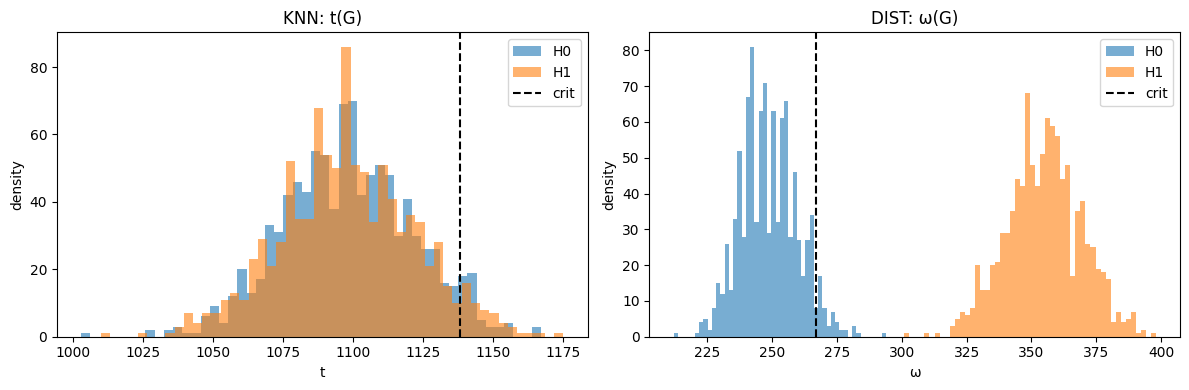

In [9]:
# 7a) Гистограммы самих статистик
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].hist(tri0, bins=50, alpha=0.6, label='H0')
ax[0].hist(tri1, bins=50, alpha=0.6, label='H1')
ax[0].axvline(crit_tri, color='k', linestyle='--', label='crit')
ax[0].set(title='KNN: t(G)', xlabel='t', ylabel='density')
ax[0].legend()

ax[1].hist(clique0, bins=50, alpha=0.6, label='H0')
ax[1].hist(clique1, bins=50, alpha=0.6, label='H1')
ax[1].axvline(crit_cl, color='k', linestyle='--', label='crit')
ax[1].set(title='DIST: ω(G)', xlabel='ω', ylabel='density')
ax[1].legend()

plt.tight_layout()
plt.show()

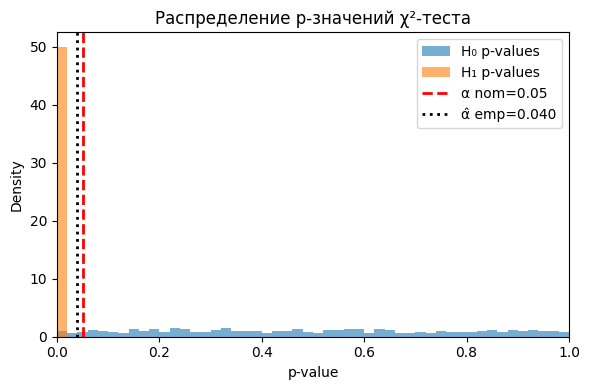

In [10]:
# 7b) Гистограмма p-значений χ²
plt.figure(figsize=(6,4))
plt.hist(p0, bins=50, range=(0,1), density=True, alpha=0.6, label='H₀ p-values')
plt.hist(p1, bins=50, range=(0,1), density=True, alpha=0.6, label='H₁ p-values')
plt.axvline(alpha,      color='r', linestyle='--', linewidth=2, label=f'α nom={alpha:.2f}')
plt.axvline(type1_chi2, color='k', linestyle=':',  linewidth=2, label=f'α̂ emp={type1_chi2:.3f}')
plt.xlim(0,1)
plt.xlabel('p-value')
plt.ylabel('Density')
plt.title('Распределение p-значений χ²-теста')
plt.legend()
plt.tight_layout()
plt.show()

**Выводы**

1. **KNN-граф (число треугольников \$t(G)\$)**
   При \$k=3\$ мощность почти равна уровню значимости (\$\beta\approx0.05\$), а даже при \$k=10\$ не поднимается выше \$\approx0.1\$.
   → \$t(G)\$ слишком «слабый» признак для разделения Normal vs Laplace: нужно либо резко увеличивать \$k\$ (граф превращается в полный), либо искать другие характеристики.

2. **DIST-граф (кликовое число \$\omega(G)\$)**
   Уже при \$d=0.2\$ и во всех больших \$d\$ мощность равна \$1.0\$.
   → \$\omega(G)\$ слишком «жёстко» разделяет выборки: сразу 100 % случаев из \$H\_1\$ выходят за порог. Для управляемой чувствительности лучше подобрать другой признак или работать с очень мелкими \$d\ll0.2\$.

3. **Классический χ²-тест (10 равноправных бинов)**
   Эмпирический уровень I рода \$\hat\alpha\approx0.047\$ близок к заданному \$0.05\$, мощность равна \$1.0\$.
   → Стабильный и информативный критерий, но зависит от дискретизации.
